In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [2]:
def load_domain_info():
    res = {}
    domains = ["bgmaps", "iron", "random10", "starcraft", "street", "dao", "maze512", "rooms"]
    for domain in domains:
        maps = os.listdir("./maps/%s" % domain)
        for m in maps:
            res[os.path.basename(m).removesuffix(".map")] = domain
    return res

def load_df(pth):
    print (pth)
    map_domain = load_domain_info()
    mapname = pth.split("/")[-1]
    df = pd.read_csv(pth, sep="\t")
    df["map"] = mapname.removesuffix(".log").removesuffix(".map").split("/")[-1]
    df["domain"] = df.apply(lambda x: map_domain.get(x["map"], "sythetic"), axis=1)
    df["scnt"] += 1
    return df

# Synthetic experiment

In [3]:
jps = pd.concat([load_df("small_output/jps/"+i) for i in os.listdir("small_output/jps")])
jpsp = pd.concat([load_df("small_output/jps-prune/"+i) for i in os.listdir("small_output/jps-prune")])
jpsp2 = pd.concat([load_df("small_output/jps-prune2/"+i) for i in os.listdir("small_output/jps-prune2")])
jps2 = pd.concat([load_df("small_output/jps2/"+i) for i in os.listdir("small_output/jps2")])
jps2p = pd.concat([load_df("small_output/jps2-prune/"+i) for i in os.listdir("small_output/jps2-prune")])
jps2p2 = pd.concat([load_df("small_output/jps2-prune2/"+i) for i in os.listdir("small_output/jps2-prune2")])

# df = pd.DataFrame.merge(jpsp, jps, on=["id", "map", "domain"], suffixes=("", "_jps"))
# df = pd.DataFrame.merge(jpsp, jps, on=["id", "map", "domain"], suffixes=("", "_jps"))
df = pd.DataFrame.merge(jps2p2, jps2, on=["id", "map", "domain"], suffixes=("", "_jps"))
# sanity checking
(df["cost"] - df["cost_jps"]).describe()

small_output/jps/maze512-16-0.map.log
small_output/jps/square-random-512.map.log
small_output/jps/maze-random.map.log
small_output/jps/diag-random-512.map.log
small_output/jps-prune/maze512-16-0.map.log
small_output/jps-prune/square-random-512.map.log
small_output/jps-prune/maze-random.map.log
small_output/jps-prune/diag-random-512.map.log
small_output/jps-prune2/maze512-16-0.map.log
small_output/jps-prune2/square-random-512.map.log
small_output/jps-prune2/maze-random.map.log
small_output/jps-prune2/diag-random-512.map.log
small_output/jps2/maze512-16-0.map.log
small_output/jps2/square-random-512.map.log
small_output/jps2/maze-random.map.log
small_output/jps2/diag-random-512.map.log
small_output/jps2-prune/maze512-16-0.map.log
small_output/jps2-prune/square-random-512.map.log
small_output/jps2-prune/maze-random.map.log
small_output/jps2-prune/diag-random-512.map.log
small_output/jps2-prune2/maze512-16-0.map.log
small_output/jps2-prune2/square-random-512.map.log
small_output/jps2-prune2

count    400.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [4]:
df["time_r"] = df["time_jps"] / df["time"]
df["scnt_r"] = df["scnt_jps"] / df["scnt"]
df["expd_r"] = df["expd_jps"] / df["expd"]
df["gen_r"] = df["gend_jps"] / df["gend"]

In [5]:
t = df[["map", "time_r"]]
t.rename(columns={"time_r": "speed up"}, inplace=True)
t["metric"] = "time"

s = df[["map", "scnt_r"]]
s.rename(columns={"scnt_r": "speed up"}, inplace=True)
s["metric"] = "scan"

e = df[["map", "expd_r"]]
e.rename(columns={"expd_r": "speed up"}, inplace=True)
e["metric"] = "expd"

tot = pd.concat([t,s,e])
tot.head()

/home/eggeek/.local/lib/python3.10/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_15508/1004472487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t["metric"] = "time"
/tmp/ipykernel_15508/1004472487.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,map,speed up,metric
0,maze512-16-0,0.542195,time
1,maze512-16-0,0.756511,time
2,maze512-16-0,0.777334,time
3,maze512-16-0,0.749957,time
4,maze512-16-0,0.767719,time


In [6]:
dfs = []
for m in tot["map"].unique():
    a = {
        "map": m,
        "metric": ["time"] * 5,
        "improve factor": [float(t[t["map"] == m].quantile(i)) for i in [0, 0.25, 0.5, 0.75, 1]]
    }
    b = {
        "map": m,
        "metric": ["scan"] * 5,
        "improve factor": [float(s[s["map"] == m].quantile(i)) for i in [0, 0.25, 0.5, 0.75, 1]]
    }
    c= {
        "map": m,
        "metric": ["expd"] * 5,
        "improve factor": [float(e[e["map"] == m].quantile(i)) for i in [0, 0.25, 0.5, 0.75, 1]]
    }
    dfs.extend([a, b, c])
t2 = pd.concat([pd.DataFrame.from_dict(i) for i in dfs])
t2.head()

,map,metric,improve factor
0,maze512-16-0,time,0.334440
1,maze512-16-0,time,0.749164
2,maze512-16-0,time,0.754220
3,maze512-16-0,time,0.761203
4,maze512-16-0,time,1.315013


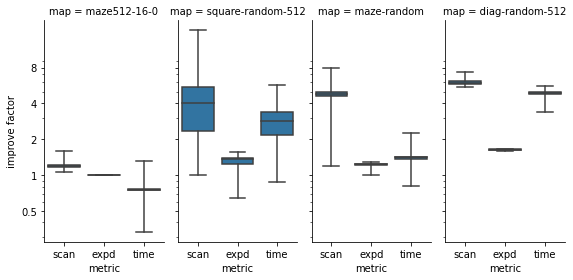

In [7]:

# sns.boxplot(x="map", y="var", hue="type", data=tot)
g = sns.FacetGrid(t2, col="map", height=4, aspect=.5)
g.map(sns.boxplot, "metric", "improve factor", whis=[0, 100], order=["scan", "expd", "time"])
axes = g.axes.flatten()
# axes[0].set_title("square-random-512")
# axes[1].set_title("maze-random-512")
# axes[2].set_title("maze512-16-0")
# axes[3].set_title("diag-random-512")
g.set(yscale="log")
plt.yticks([0.5, 1, 2, 4, 8], ['0.5', '1', '2', '4', '8'])
g.savefig("./output/figs/synthetic.pdf")

In [8]:
dft = df.groupby("map")["time_r"].describe().round(2).drop(["count", "mean", "std"], axis=1)
dft

,min,25%,50%,75%,max
map,,,,,
diag-random-512,3.42,4.77,4.90,4.98,5.59
maze-random,0.82,1.37,1.41,1.43,2.24
maze512-16-0,0.33,0.75,0.75,0.76,1.32
square-random-512,0.87,2.17,2.85,3.39,5.67


In [10]:
dfs = df.groupby("map")["scnt_r"].describe().round(2).drop(["count", "mean", "std"], axis=1)
dfs

,min,25%,50%,75%,max
map,,,,,
diag-random-512,5.51,5.87,5.97,6.16,7.29
maze-random,1.19,4.63,4.82,5.03,7.94
maze512-16-0,1.06,1.17,1.19,1.22,1.60
square-random-512,1.01,2.36,4.01,5.51,16.40


In [11]:
dfe = df.groupby("map")["expd_r"].describe().round(2).drop(["count", "mean", "std"], axis=1)
dfe

,min,25%,50%,75%,max
map,,,,,
diag-random-512,1.59,1.62,1.64,1.65,1.67
maze-random,1.00,1.22,1.23,1.24,1.29
maze512-16-0,1.00,1.00,1.00,1.00,1.00
square-random-512,0.64,1.23,1.36,1.40,1.55


In [45]:
print("time improvement\n", dft.to_latex(), "scan improvement\n", dfs.to_latex(), "expd improvement\n", dfe.to_latex())

time improvement
 \begin{tabular}{lrrrrr}
\toprule
{} &   min &   25\% &   50\% &   75\% &   max \\
map               &       &       &       &       &       \\
\midrule
diag-random-512   &  1.34 &  2.18 &  2.24 &  2.32 &  2.60 \\
maze-random       &  0.97 &  1.41 &  1.46 &  1.50 &  1.70 \\
maze512-16-8      &  0.56 &  0.93 &  0.93 &  0.94 &  1.23 \\
square-random-512 &  0.87 &  1.12 &  1.25 &  1.31 &  1.89 \\
\bottomrule
\end{tabular}
 scan improvement
 \begin{tabular}{lrrrrr}
\toprule
{} &   min &   25\% &   50\% &   75\% &   max \\
map               &       &       &       &       &       \\
\midrule
diag-random-512   &  2.44 &  2.48 &  2.50 &  2.53 &  2.68 \\
maze-random       &  1.00 &  1.86 &  1.95 &  1.97 &  2.11 \\
maze512-16-8      &  1.00 &  1.00 &  1.00 &  1.00 &  1.00 \\
square-random-512 &  1.00 &  1.12 &  1.25 &  1.37 &  2.79 \\
\bottomrule
\end{tabular}
 expd improvement
 \begin{tabular}{lrrrrr}
\toprule
{} &   min &   25\% &   50\% &   75\% &   max \\
map               

# Domain experiment

In [16]:
# rect = pd.concat([load_df("output/rect/"+i) for i in os.listdir("output/rect")])
# jps = pd.concat([load_df("output/jps/"+i) for i in os.listdir("output/jps")])
# jpsp = pd.concat([load_df("output/jps-prune/"+i) for i in os.listdir("output/jps-prune")])
# jpsp2 = pd.concat([load_df("output/jps-prune2/"+i) for i in os.listdir("output/jps-prune2")])
jps2 = pd.concat([load_df("output/jps2/"+i) for i in os.listdir("output/jps2")])
# jps2p = pd.concat([load_df("output/jps2-prune/"+i) for i in os.listdir("output/jps2-prune")])
jps2p2 = pd.concat([load_df("output/jps2-prune2/"+i) for i in os.listdir("output/jps2-prune2")])
# df = pd.DataFrame.merge(jpsp2, jps, on=["id","map", "domain"], suffixes=("", "_jps"))
df = pd.DataFrame.merge(jps2p2, jps2, on=["id","map", "domain"], suffixes=("", "_jps"))
# sanity checking
(df["cost"] - df["cost_jps"]).describe()

output/jps2/scene_sp_rus_01.map.log
output/jps2/scene_sp_rus_05.map.log
output/jps2/Sandstorm.map.log
output/jps2/AR0317SR.map.log
output/jps2/den012d.map.log
output/jps2/orz106d.map.log
output/jps2/brc300d.map.log
output/jps2/Eruption.map.log
output/jps2/SpaceDebris.map.log
output/jps2/den404d.map.log
output/jps2/orz301d.map.log
output/jps2/RedCanyons.map.log
output/jps2/AR0410SR.map.log
output/jps2/scene_sp_pol_06.map.log
output/jps2/AR0041SR.map.log
output/jps2/Denver_2_256.map.log
output/jps2/lak103d.map.log
output/jps2/London_1_256.map.log
output/jps2/lak505d.map.log
output/jps2/Berlin_1_512.map.log
output/jps2/AR0506SR.map.log
output/jps2/orz702d.map.log
output/jps2/NewYork_1_256.map.log
output/jps2/Moscow_1_256.map.log
output/jps2/scene_sp_pol_03.map.log
output/jps2/AR0400SR.map.log
output/jps2/AR0201SR.map.log
output/jps2/Denver_1_1024.map.log
output/jps2/AR0014SR.map.log
output/jps2/Boston_0_512.map.log
output/jps2/ShroudPlatform.map.log
output/jps2/IceFloes.map.log
output/jps

count    800425.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

In [17]:
df["ratio_t"] = df["time_jps"] / df["time"]
df["ratio_s"] = df["scnt_jps"] / df["scnt"]
df["ratio_g"] = df["expd_jps"] / df["expd"]
t = df[["ratio_t", "ratio_s", "ratio_g", "map", "cost", "expd", "domain", "expd_jps", "scnt_jps"]]
t.head()

,ratio_t,ratio_s,ratio_g,map,cost,expd,domain,expd_jps,scnt_jps
0,0.594325,1.131148,1.0,scene_sp_rus_01,2.4142,1,iron,1,69
1,0.605691,1.000000,1.0,scene_sp_rus_01,3.4142,1,iron,1,66
2,0.583527,1.061224,1.0,scene_sp_rus_01,3.4142,1,iron,1,52
3,0.578629,1.000000,1.0,scene_sp_rus_01,3.4142,1,iron,1,31
4,0.542587,1.111111,1.0,scene_sp_rus_01,1.4142,1,iron,1,10


In [18]:
t.groupby("domain")["ratio_t"].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
domain,,,,,,,,
bgmaps,122600.0,0.86,0.47,0.01,0.77,0.81,0.87,56.03
dao,159465.0,0.95,0.81,0.01,0.80,0.88,1.01,121.57
iron,55520.0,0.93,0.32,0.02,0.82,0.88,0.98,17.91
maze512,57020.0,0.83,0.18,0.05,0.73,0.78,0.94,12.89
random10,1670.0,1.02,0.16,0.39,0.96,1.03,1.08,3.07
rooms,8430.0,0.77,0.19,0.06,0.71,0.75,0.80,3.90
starcraft,198230.0,0.95,0.30,0.01,0.83,0.90,1.01,46.58
street,197490.0,0.90,0.31,0.02,0.81,0.86,0.93,47.90


In [19]:
t.groupby("domain")["ratio_g"].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
domain,,,,,,,,
bgmaps,122586.0,1.01,0.03,0.36,1.0,1.00,1.00,2.50
dao,159425.0,1.04,0.06,0.17,1.0,1.01,1.08,1.89
iron,55513.0,1.03,0.04,0.14,1.0,1.01,1.05,1.82
maze512,57016.0,1.00,0.00,1.00,1.0,1.00,1.00,1.00
random10,1670.0,1.03,0.05,0.49,1.0,1.02,1.07,1.67
rooms,8429.0,1.01,0.01,1.00,1.0,1.00,1.01,1.07
starcraft,198230.0,1.04,0.06,0.12,1.0,1.01,1.06,3.83
street,197475.0,1.01,0.03,0.17,1.0,1.00,1.00,2.43


In [20]:
print(t.groupby("domain")["ratio_t"].describe().round(2).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &     count &  mean &   std &   min &   25\% &   50\% &   75\% &     max \\
domain    &           &       &       &       &       &       &       &         \\
\midrule
bgmaps    &  122600.0 &  0.86 &  0.47 &  0.01 &  0.77 &  0.81 &  0.87 &   56.03 \\
dao       &  159465.0 &  0.95 &  0.81 &  0.01 &  0.80 &  0.88 &  1.01 &  121.57 \\
iron      &   55520.0 &  0.93 &  0.32 &  0.02 &  0.82 &  0.88 &  0.98 &   17.91 \\
maze512   &   57020.0 &  0.83 &  0.18 &  0.05 &  0.73 &  0.78 &  0.94 &   12.89 \\
random10  &    1670.0 &  1.02 &  0.16 &  0.39 &  0.96 &  1.03 &  1.08 &    3.07 \\
rooms     &    8430.0 &  0.77 &  0.19 &  0.06 &  0.71 &  0.75 &  0.80 &    3.90 \\
starcraft &  198230.0 &  0.95 &  0.30 &  0.01 &  0.83 &  0.90 &  1.01 &   46.58 \\
street    &  197490.0 &  0.90 &  0.31 &  0.02 &  0.81 &  0.86 &  0.93 &   47.90 \\
\bottomrule
\end{tabular}



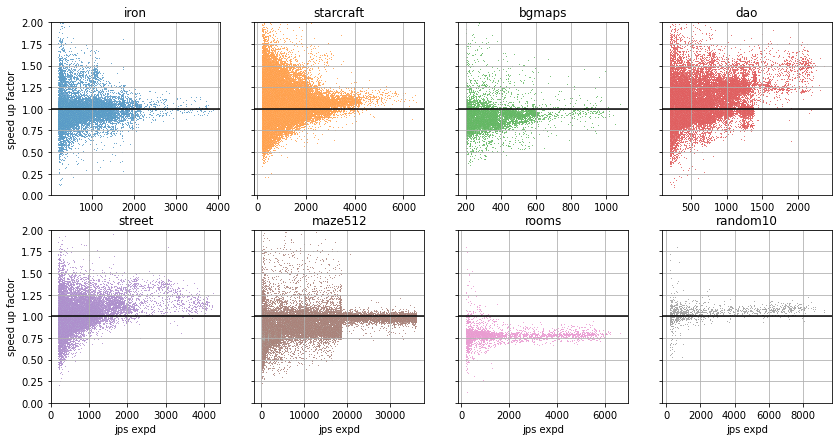

In [21]:
from math import ceil
domains = t["domain"].unique()
ndomain = len(domains)
minexpd = 200
mincost = 100
nrows   = 2
ncols   = int(ceil(ndomain / nrows))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=(3.5*ncols, 3.5*nrows))
if ndomain == 1:
    axes = [axes]
colors = sns.color_palette()

for i in range(ndomain):
    g = t[t["domain"] == domains[i]]
    g = g[g["expd_jps"] > minexpd]
    axi = axes[i // ncols][i % ncols]
    g = sns.scatterplot(x="expd_jps", y="ratio_t", color=colors[i], data=g, ax=axi, s=1)

    g.axhline(1, color="black")
    axi.grid()
    axi.set_yscale("linear")
    axi.set_xlabel("")
    axi.set_ylabel("")
    axi.set_title(domains[i])
    axi.set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])
    axi.set_ylim([0, 2])

for i in range(nrows):
    axes[i][0].set_ylabel("speed up factor")
for i in range(ncols):
    axes[nrows-1][i].set_xlabel("jps expd")
fig.savefig("./output/figs/domain_cmp.png")

In [15]:
z = (df.groupby("domain")[["time", "time_jps"]].sum() / 1000000).round(2)
z

,time,time_jps
domain,,
bgmaps,3.32,3.07
dao,11.60,12.14
iron,6.13,5.88
maze512,58.46,51.59
random10,1.07,1.23
rooms,2.07,1.83
starcraft,30.08,29.42
street,17.21,16.08


In [127]:
print(z.to_latex())

\begin{tabular}{lrr}
\toprule
{} &    time &  time\_jps \\
domain    &         &           \\
\midrule
bgmaps    &    3.17 &      3.23 \\
dao       &   40.13 &     47.26 \\
iron      &    6.31 &      7.21 \\
maze512   &  691.46 &    672.37 \\
random10  &   13.86 &     15.06 \\
rooms     &   25.79 &     25.68 \\
starcraft &   31.30 &     34.66 \\
street    &   14.38 &     15.12 \\
\bottomrule
\end{tabular}



# Best and Worst of each Domain

In [37]:
df["time_r"] = df["time_jps"] / df["time"]
df["scnt_r"] = df["scnt_jps"] / df["scnt"]
df["expd_r"] = df["expd_jps"] / df["expd"]

In [38]:
tmp = df[df["expd_r"]>1].groupby(["domain", "map"]).median().reset_index()[["map", "domain", "time_r", "scnt_r", "expd_r"]]
tmp.sort_values("time_r", ascending=False)

,map,domain,time_r,scnt_r,expd_r
25,AR0308SR,bgmaps,1.704163,3.586457,1.088608
8,AR0020SR,bgmaps,1.621777,1.200214,1.076923
309,Denver_2_1024,street,1.573783,2.074105,1.054054
165,ost100d,dao,1.377911,3.428662,1.109827
311,Denver_2_512,street,1.373522,2.168975,1.045455
...,...,...,...,...,...
207,32room_000,rooms,0.720054,1.380654,1.010135
169,rmtst03,dao,0.685625,1.237340,1.052778
146,orz301d,dao,0.642341,1.075645,1.027402
147,orz302d,dao,0.635795,1.245810,1.055556


In [43]:
dfm= df.groupby(["map", "domain"]).median().reset_index()
metric = "time_r"

idx = dfm.groupby(["domain"])[metric].transform(max) == dfm[metric]
dmax = dfm[idx]

idx = dfm.groupby(["domain"])[metric].transform(min) == dfm[metric]
dmin = dfm[idx]

In [44]:
dmax[dmax["time_r"] > 1][["map", "domain", "time_r", "scnt_r", "expd_r"]]

,map,domain,time_r,scnt_r,expd_r
122,Denver_2_256,street,1.035678,1.222510,1.000000
218,SpringThaw,starcraft,1.139126,1.949472,1.047131
397,ost100d,dao,1.286788,2.966830,1.087137
403,random512-10-0,random10,1.026190,2.367180,1.016878


dmin[["map", "domain", "time_r", "scnt_r", "expd_r"]]

# Visualize Map

In [5]:
from matplotlib.patches import Rectangle

In [19]:
# files = [i for i in os.listdir("./output") if i.endswith(".csv")]
files = [
    "maze512.csv", 
    "room.csv",
    "endmaps.csv", 
    "GreenerPastures.csv", 
]
df = pd.concat([pd.read_csv("./output/"+i, sep="\t") for i in files])
df.head()

,map,mapw,maph,x,y,traversable
0,../maps/maze512/maze512-32-0.map,512,512,0,0,1
1,../maps/maze512/maze512-32-0.map,512,512,1,0,1
2,../maps/maze512/maze512-32-0.map,512,512,2,0,1
3,../maps/maze512/maze512-32-0.map,512,512,3,0,1
4,../maps/maze512/maze512-32-0.map,512,512,4,0,1


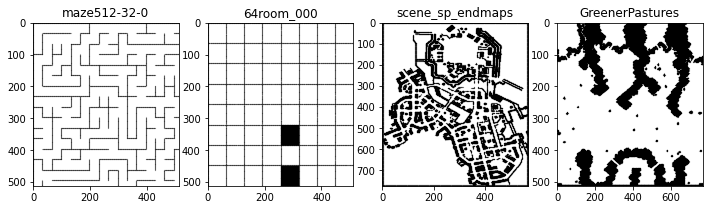

In [20]:
maps = df["map"].unique()
nmap = len(maps)
fig, axes = plt.subplots(nrows=1, ncols=nmap, figsize=(nmap*3, 3), sharex=False, sharey=False)
if nmap == 1:
    axes = [axes]
for i, m in enumerate(maps):
    g = df[(df["map"] == m)]
    axes[i].set_xlim(0, g["mapw"].min())
    axes[i].set_ylim(0, g["maph"].min())
    axes[i].invert_yaxis()
    axes[i].scatter(x=g[g["traversable"] == 1]["x"], y=g[g["traversable"] == 1]["y"], c="black", s=0.01)
    axes[i].set_title(m.split("/")[-1].removesuffix(".map"))

plt.savefig("./output/figs/visual_maps.png")

In [35]:
# a = pd.read_csv("icemountain_jps2.log", sep="\t")
# b = pd.read_csv("icemountain_jps2p2.log", sep="\t")
# c = pd.merge(a, b, on=["id"], suffixes=["_jps2", ""])
a = pd.read_csv("caldera_jps2.log", sep="\t")
b = pd.read_csv("caldera_jps2p2.log", sep="\t")
c = pd.merge(a, b, on=["id"], suffixes=["_jps2", ""])

In [36]:
(c["time_jps2"] / c["time"]).describe()

count    50.000000
mean      0.943277
std       0.242817
min       0.567849
25%       0.838405
50%       0.915847
75%       1.028678
max       2.173657
dtype: float64